# Participant-level Partisan News

This notebook loads, reshapes, and plots participant-level distributions of  
partisan news exposure, follows, and engagement. The data needed to run this  
file are not publicly available because only aggregated data may be released.

In [1]:
# Set the working directory to the downloaded folder
!cd /home/rer/proj/gssurvey/notebooks/final

## Required Packages

In [2]:
import string
import itertools
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import custom functions
import sys
sys.path.insert(0, ".")
from functions import read_json, stringify, mm_to_inches
from functions import remove_xaxis_ticks, remove_yaxis_ticks, reorder_legend

## Figure Settings

In [3]:
# ==============================================================================
# Plot colors and labels
label_colors = read_json('plot_colors.json')
label_orders = read_json('plot_labels.json')

# Color maps
pid7_colors = [
    "#00488C",
    "#0074E0",
    "#428bca", 
    "#cbcaca",
    "#d27979",
    "#d31d0e",
    "#8a0f00"
]
palette_alt = dict(zip(label_orders['pid7_reduced'], pid7_colors))

# ==============================================================================
# Figure sizes
# https://www.nature.com/documents/Final_guide_to_authors.pdf
# sizes: 89mm, 120mm, 183mm
FIG_WIDTH = {
    "sm": mm_to_inches(89),
    "md": mm_to_inches(120),
    "lg": mm_to_inches(180),
}
print("Figure Widths:\n", FIG_WIDTH)

# ==============================================================================
# Font settings

# Output fonts in pdf as text not shape
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# "Separate panels in multi-part figures should be labelled with 8-pt bold,
# upright (not italic) a, b, c, etc. Maximum text size for all other text: 7 pt.
# Minimum text size: 5 pt"
TINY_SIZE = 6
SMALL_SIZE = 7
LARGE_SIZE = 8

# Set default font size and family
font = {'family' : "Arial", 
        'weight' : 'regular',
        'size'   : SMALL_SIZE}
plt.rc('font', **font)   
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

# Subplot letter font
text_letters_kws = {
    "ha": "center", 
    "va": "center", 
    "rotation": 0, 
    "weight": "bold", 
    "size": LARGE_SIZE,
}

# Title text
title_kws = {
    'ha': 'center', 
    'va': 'center', 
    'size': SMALL_SIZE
}

# Legend text
legend_base_kws = {
    'prop': {'size': TINY_SIZE},
    'frameon': False, 
}

Figure Widths:
 {'sm': 3.5039370078740157, 'md': 4.724409448818897, 'lg': 7.086614173228346}


In [4]:
# Load participant-level datasets
# NOTE: these datasets are not included in replication materials, see README.md
data2018 = pd.read_csv('data/participant_partisanship2018.csv')
data2020 = pd.read_csv('data/participant_partisanship2020.csv')
data = pd.concat([data2018, data2020])

# Combine 2018 and 2020 user IDs into one columns
mask = data['user_id'].isnull()
data.loc[mask, 'user_id'] = data.loc[mask, 'caseid']
data.drop(columns=['caseid'], inplace=True)

# Reorder columns
cols = ["year", "datatype", "dataset", "pid7_reduced", "user_id",
        "bias_score_bin", "p"]
data = data[cols]

print(data.shape)
data.drop(columns=['user_id']).head() # user_id omitted for participant privacy

(63320, 7)


,year,datatype,dataset,pid7_reduced,bias_score_bin,p
0,2018,Google Search Exposure,Google SERPs,Strong Republican,"(-1.0, -0.9]",0.000000
1,2018,Google Search Exposure,Google SERPs,Strong Republican,"(-0.9, -0.8]",0.000000
2,2018,Google Search Exposure,Google SERPs,Strong Republican,"(-0.8, -0.7]",0.005202
3,2018,Google Search Exposure,Google SERPs,Strong Republican,"(-0.7, -0.6]",0.016905
4,2018,Google Search Exposure,Google SERPs,Strong Republican,"(-0.6, -0.5]",0.035111


In [5]:
# To declutter, xticklabels show midpoint of bin rather than range
# e.g. instead of '-1.0 - 0.9' we use '-0.95'
labels = [
    '-0.95', 
    '-0.85', 
    '-0.75', 
    '-0.65', 
    '-0.55', 
    '-0.45', 
    '-0.35', 
    '-0.25', 
    '-0.15', 
    '-0.05', 
    '0.05', 
    '0.15', 
    '0.25', 
    '0.35', 
    '0.45', 
    '0.55', 
    '0.65', 
    '0.75', 
    '0.85', 
    '0.95', 
]

label_map = dict(zip(data["bias_score_bin"].unique(), labels))
data['bias_score_bin'] = data['bias_score_bin'].map(label_map)
data.drop(columns=['user_id']).head() # user_id omitted for participant privacy

,year,datatype,dataset,pid7_reduced,bias_score_bin,p
0,2018,Google Search Exposure,Google SERPs,Strong Republican,-0.95,0.000000
1,2018,Google Search Exposure,Google SERPs,Strong Republican,-0.85,0.000000
2,2018,Google Search Exposure,Google SERPs,Strong Republican,-0.75,0.005202
3,2018,Google Search Exposure,Google SERPs,Strong Republican,-0.65,0.016905
4,2018,Google Search Exposure,Google SERPs,Strong Republican,-0.55,0.035111


## Figure: Participant-level Partisan News

In [6]:
# Settings
uid = 'user_id'
group = "pid7_reduced"
metric = "bias_score_bin"
labels = ['Strong Democrat', 'Independent/Not sure', 'Strong Republican']    

def individual_partisanship_plot(subset, ax, uid=uid, group=group, labels=labels):
    """Plot a line for each participants' binned partisan news distribution"""
    
    for (uid, label), gdf in subset.groupby([uid, group]):  

        if label in labels:
            ax.plot(gdf[metric].astype(str), gdf['p'], 
                    color=label_colors[group][label],
                    label=label, **pplot_kws)

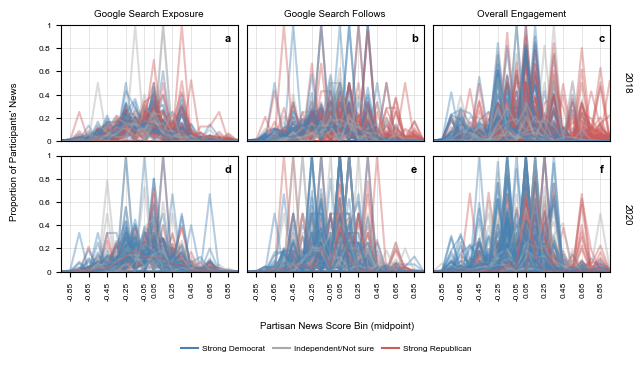

saved: figures/partisan_news_participant_level.png
saved: figures/partisan_news_participant_level.tiff
saved: figures/partisan_news_participant_level.pdf


In [7]:
# ==============================================================================
# Plot arguments

IMG_PATH = 'outputs/figures/partisan_news_participant_level.png'
OVERWRITE = True

subplot_kws = {
    "figsize":(FIG_WIDTH['lg'], 3.5),
    'sharex': True,
    'sharey': True,
    'gridspec_kw': {'hspace': 0.125, 'wspace':0.05},
}

pplot_kws = {
    'linestyle': '-',
    'marker': '.',
    'markersize': 0.1,
    'alpha': 0.4,
}

grid_kws = {
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

fig, axs = plt.subplots(nrows=2, ncols=3, **subplot_kws)
axs = axs.flatten()

# ==============================================================================
# Plot 2018 Variables    
            
# Exposure
dt = 'Google Search Exposure'
subset = data.query("year == 2018 & datatype == @dt")
individual_partisanship_plot(subset, axs[0])
remove_xaxis_ticks(axs[0])
axs[0].set(title=dt)
axs[0].legend()

# Follows
dt = 'Google Search Follows'
subset = data.query("year == 2018 & datatype == @dt")
individual_partisanship_plot(subset, axs[1])
remove_xaxis_ticks(axs[1])
remove_yaxis_ticks(axs[1])
axs[1].set(title=dt)

# Overall Engagement
dt = 'Overall Engagement'
subset = data.query("year == 2018 & datatype == @dt & dataset == 'Browser History'")
individual_partisanship_plot(subset, axs[2])
remove_xaxis_ticks(axs[2])
remove_yaxis_ticks(axs[2])
axs[2].set(title=dt)
         
# ==============================================================================
# Plot 2020 Variables

# Exposure
dt = 'Google Search Exposure'
subset = data.query("year == 2020 & datatype == @dt")
individual_partisanship_plot(subset, axs[3])

# Follows
dt = 'Google Search Follows'
subset = data.query("year == 2020 & datatype == @dt")
individual_partisanship_plot(subset, axs[4])
remove_yaxis_ticks(axs[4])

# Overall Engagement
dt = 'Overall Engagement'
subset = data.query("year == 2020 & datatype == @dt & dataset == 'Browser History'")
individual_partisanship_plot(subset, axs[5])
remove_yaxis_ticks(axs[5])

axs[0].set(ylim=(0,1), 
           yticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
           yticklabels=['0','0.2', '0.4', '0.6', '0.8', '1'])

# Filtered xticks for readability
xticks = [
    '-0.85', 
    '-0.65', 
    '-0.45', 
    '-0.25', 
    '-0.05', 
    '0.05', 
    '0.25', 
    '0.45', 
    '0.65', 
    '0.85', 
]
axs[3].set(xticks=xticks, xlim=('-0.95', '0.95'))

xtick_label_kws = dict(
    rotation=90, 
    ha="right", 
    va="center_baseline", 
    rotation_mode='anchor',
)

for i in range(3, 6):
    axs[i].set_xticklabels(xticks, **xtick_label_kws)
    
# ==============================================================================
# Format Legend

# Get legend handles and labels
handles, axlabels = axs[0].get_legend_handles_labels()
handles, axlabels = reorder_legend(handles, axlabels, order=labels, unique=True)
axs[0].legend_.remove()

# Right-hand legend
legend = fig.legend(handles, axlabels, 
    ncol=3,
    frameon=False, 
    markerscale=1.1, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.075, 0, 0),
    prop={'size': TINY_SIZE},
    handletextpad=0.5,
    columnspacing=1,
)

for lh in legend.legendHandles: 
    lh.set_alpha(1)

# ==============================================================================
# Adjustments

# Add grids
for _ax in axs:
    _ax.grid(axis='both', which='major', **grid_kws)

# Spacing between xlabel and legend
fig.subplots_adjust(bottom=0.175)

# Meta labels
text_kws = dict(ha='center', va='center', size=SMALL_SIZE)
fig.text(0.925, 0.715, "2018", rotation=270, **text_kws)
fig.text(0.925, 0.34, "2020", rotation=270, **text_kws)

text_kws = dict(ha='center', va='center', size=SMALL_SIZE)
fig.text(0.06, 0.520, "Proportion of Participants' News", rotation=90, **text_kws)
fig.text(0.515, 0.02, "Partisan News Score Bin (midpoint)", **text_kws)

# Subplot labels
text_x = [0.361, 0.624, 0.889]
text_y = [0.842, 0.468]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)

# ==============================================================================
# Save as PNG and PDF

plt.show()
if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.tiff'), dpi=300, bbox_inches='tight')
    fig.savefig(IMG_PATH.replace('.png','.pdf'), bbox_inches='tight')
    print(f"saved: {IMG_PATH}")
    print(f"saved: {IMG_PATH.replace('.png','.tiff')}")
    print(f"saved: {IMG_PATH.replace('.png','.pdf')}")